# Flat Pipeline

In [1]:
from typing import Iterable, Any
import yaml
import polars as pl

from nebula.base import Transformer, LazyWrapper, is_ns_lazy_request
from nebula.pipelines.util import *
from nebula.pipelines.util import _get_transformer_params_formatted

from nebula.transformers import *
from nebula.storage import nebula_storage as ns
from nebula.pipelines.pipeline import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline

%load_ext autoreload
%autoreload 2

## Create a pipeline using python

3 transformers:

- EmptyStringToNull
- Distinct
- CoalescePartitions

To show the pipeline steps without actually running it, call the method `show`.

In [2]:
def simple_function(_df):
    print(f"Hello I'm 'simple_function' -> this is a: {type(_df)}")
    return _df


def function_with_args_and_kwargs(_df, *args, coef, factor):
    print(f"Hello I'm 'function_with_args_and_kwargs' -> this is a: {type(_df)}")
    return _df

def add_1(df, *args):
    value_to_add = args[0] + 1
    print(f"Add the value {value_to_add}")
    return value_to_add

ns.clear()

pipe = TransformerPipeline(
    [
        DropColumns(columns=[f"not_exist_{i}" for i in range(10)], allow_excess_columns=True),
        (SelectColumns(columns=["c2", "c3"]), "select only a couple of columns"),
        SelectColumns(columns=["c2", "c3"]),
        AssertNotEmpty(),
        LazyWrapper(AddLiterals, data=[{"alias": "c4", "value": (ns, "my_key")}]),
        None,
        simple_function,
        (function_with_args_and_kwargs, [1, 2, 3, 4, 5], {"coef": 10, "factor": [20, {"a": 30}]}),
        TransformerPipeline([AssertNotEmpty(), AssertNotEmpty()])
    ],
    # name="Example pipeline",
)

print("PRINT WITHOUT PARAMS")
pipe.show(add_params=False)
print("\nPRINT WITH PARAMS")
pipe.show(add_params=True)

2025-12-25 01:43:36,845 | [INFO]: Nebula Storage: clear. 
2025-12-25 01:43:36,848 | [INFO]: Nebula Storage: 0 keys remained after clearing. 


PRINT WITHOUT PARAMS
*** Pipeline *** (9 transformations)
 - DropColumns
 - SelectColumns
     Description: select only a couple of columns
 - SelectColumns
 - AssertNotEmpty
 - (Lazy) AddLiterals
 - simple_function
 - function_with_args_and_kwargs
*** Pipeline *** (2 transformations)
 - AssertNotEmpty
 - AssertNotEmpty

PRINT WITH PARAMS
*** Pipeline *** (9 transformations)
 - DropColumns -> PARAMS: allow_excess_columns=True, columns=[' ... ist_7', 'not_exist_8', 'not_exist_9']
 - SelectColumns -> PARAMS: columns=['c2', 'c3']
     Description: select only a couple of columns
 - SelectColumns -> PARAMS: columns=['c2', 'c3']
 - AssertNotEmpty
 - (Lazy) AddLiterals -> PARAMS: data=[{'alias': 'c4', 'value': 'ns.get("my_key")'}]
 - simple_function
 - function_with_args_and_kwargs -> ARGS=[1, 2, 3, 4, 5], KWARGS={'coef': 10, 'factor': [20, {'a': 30}]}
*** Pipeline *** (2 transformations)
 - AssertNotEmpty
 - AssertNotEmpty


### If graphviz is installed

https://graphviz.org/download/

To render the the pipeline, call the method `plot`.<br>

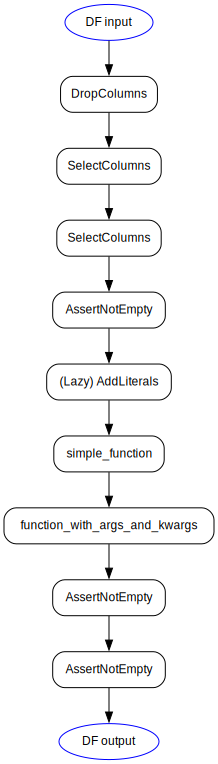

In [3]:
pipe.plot(add_params=False)

To add the transformer parameters, simply set `add_params=True` in the `show` method as follows:

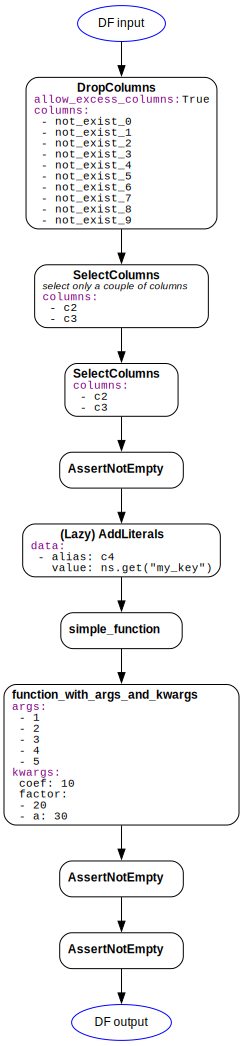

In [4]:
pipe.plot(add_params=True, add_description=True)

## Actual run

In [ ]:
ns.set("my_key", "k1")

In [ ]:
df_input = pl.DataFrame({"c1": [1, 2], "c2": [3, 4], "c3": [5, 6]})

df_out = pipe.run(df_input, show_params=True)
df_out.show()

## Create the same pipeline using yaml

In [ ]:
yml_data = """
pipeline:
  - transformer: EmptyStringToNull
    params:
      columns: ["c2", "c3"]
  - transformer: Distinct
  - transformer: CoalescePartitions
    params:
        num_partitions: 5
"""

pipe_cfg = yaml.safe_load(yml_data)

# from nebula.spark_pipelines.pipeline_loader import load_pipeline
pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_params=True)

In [ ]:
pipe.run(df_input).show()